In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import tqdm
import re
from functools import cmp_to_key

warnings.filterwarnings("ignore")

with open("../../datasets/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [2]:
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

In [3]:
# Разбитие на анектоды
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]
cut_text = cut_data(text)

In [4]:
import random
cut_text[random.randint(0, 31000)]

'Компьютерщик со стажем, садясь в машину вставляет ключ и ждет, когда на приборной доске высветится сообщение о его обнаружении и успешной инсталляции...'

In [5]:
allowed_symbols = {'\n', ':', ';', '=', '>', '?', '@', ' ', '!', '"', '#', '$', '%', '&', '\'', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

allowed_symbols2 = {'\n', ':', ';', '=', '>', '?', '@', ' ', '!', '"', '#', '$', '%', '&', '\'', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

allowed_symbols2_rus = {':', ';', '?', '@', ' ', '!', '"', '#', '$', '%', '*', '+', ',', '\-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Ё', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё'}

In [6]:
GLOBAL_MAX_TOKEN_LEN = 5
GLOBAL_MAX_TOKEN_COUNT = 519

# Задание 4. RNN
## Задача 1. 3 балла
Обучите RNN/LSTM на данных из классной работы, используя другой токенайзер. Опишите его и свой выбор. Покажите разницу в генерации моделей, обученных с разными токенайзерами.
## {*} Задача 1.1 2 балла
Напишите свой токенайзер вручную, с использованием только библиотек numpy, torch, sklearn, stats, опционально других пакетов, не предоставляющих готовые инструменты токенизации и т.п., за исключением предобработки текста (лемматизация, стеминг и т.д.) . 


In [7]:
class Custom_Tokenizer:
    def __init__(self, cut_text, max_count_token: int = 512, max_token_len = 2, allowed_s = allowed_symbols2_rus):
        self.allowed_s = allowed_s
        self.max_token_len = max_token_len
        self.text = cut_text
        self.max_count_token = max_count_token
        self.specials = {'<pad>':999999, '<bos>':999999, '<eos>':999999}
        
        self.create_vocab("".join(self.text))
        
    def token_compare(self, item1:dict, item2:dict):
        if ((" " in item1[0] or " " in item2[0]) and not(item1[0] == " " or item2[0] == " ")):
            #print(item1[0], item2[0])
            if (" " in item1[0] and " " in item2[0]):
                return 0
            elif (" " in item1[0]):
                return 1
            else:
                return -1
        else:
            #if (len(item2[0]) > len(item1[0]) and item2[0])
            return item2[1] - item1[1]
    
    def create_vocab(self, text: str):
        regex = r'[^' + "".join(self.allowed_s).lower() + ']'
        reg = re.compile(regex)
        text = reg.sub('', text.replace('ё', 'е'))
    
        my_dict = {}
        i = 1
        text_len = len(text)
        for index in range(0, text_len - i + 1):
            token = text[index:index+i]
            if not token in my_dict:
                my_dict[token]=9999999
    
        text = re.sub(r'[^а-я ]', '', text)

    
        for i in range (2, self.max_token_len+1):
            text_len = len(text)
            for index in range(0, text_len - i + 1):
                token = text[index:index+i]
                if token in my_dict:
                    my_dict[token]+=1
                else:
                    my_dict[token]=1
                # Assign unique IDs to tokens
        
        # отсортировали по принципу с пробелом в конец, 1 символ в начало,
        #   остальное по частоте, чтобы лего сделать crop
        sorted_tokens = dict(sorted(my_dict.items(), key=cmp_to_key(self.token_compare))[:self.max_count_token])
        # Сортируем по длине токена, а после по частоте
        sorted_tokens.update(self.specials)

        sorted_tokens = sorted(sorted_tokens.items(), key=lambda x: (-len(x[0]), -x[1]))

        self.token_to_id = {token: idx for idx, (token, _) in enumerate(sorted_tokens)}
        self.id_to_token = {idx: token for token, idx in self.token_to_id.items()}
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.token_to_id)
        self.token_to_id[symbol] = sym_num
        self.id_to_token[sym_num] = symbol
    
    @property
    def vocab_size(self):
        return len(self.token_to_id) # your code
    
    def decode_symbol(self, el):
        return self.id_to_token[el]
        
    def encode_symbol(self, el):
        return self.token_to_id[el]

    #@property
    def tokenize(self, text: str):
        """
        Tokenizes the input text into numbers using the built dictionary.
        :param text: Input text to tokenize.
        :return: A list of token IDs representing the text.
        """
        
        if not self.token_to_id:
            raise ValueError("Tokenizer dictionary is empty. Call 'build_dict' first.")
        
        tokens = []
        i = 0
        while i < len(text):
            match = None
            # Try to find the longest matching token
            for size in range(max(self.max_token_len, 5), 0, -1):
                if i + size <= len(text):
                    substring = text[i:i + size]
                    if substring in self.token_to_id:
                        match = substring
                        break
            
            if match:
                tokens.append(self.token_to_id[match])
                i += len(match)  # Move past the matched token
            else:
                # If no match, handle single characters (fallback)
                tokens.append(self.token_to_id[text[i]])
                i += 1
        
        return tokens
    
    def detokenize(self, token_ids):
        """
        Converts token IDs back into the original text using the dictionary.
        :param token_ids: A list of token IDs.
        :return: The reconstructed text.
        """
        return ''.join(self.id_to_token[token_id] for token_id in token_ids)
    
    def encode(self, chars, eos=True):
        regex = r'[^' + "".join(self.allowed_s) + ']'
        reg = re.compile(regex)
        chars = reg.sub('', chars.lower().replace('ё', 'е'))

        if eos:
            chars = '<bos>' + chars + '<eos>'
        else:
            chars = '<bos>' + chars
        return self.tokenize(chars)

    def decode(self, idx):
        return self.detokenize(idx)

In [8]:
My_CT = Custom_Tokenizer(cut_text,
                 max_count_token=GLOBAL_MAX_TOKEN_COUNT,
                 max_token_len = GLOBAL_MAX_TOKEN_LEN,
                 allowed_s = allowed_symbols2_rus)

In [9]:
print("Token Dictionary:", My_CT.token_to_id)

Token Dictionary: {'<pad>': 0, '<bos>': 1, '<eos>': 2, 'олько': 3, 'когда': 4, 'говор': 5, 'ается': 6, 'огда': 7, 'ется': 8, 'ольк': 9, 'лько': 10, 'меня': 11, 'вает': 12, 'овор': 13, 'когд': 14, 'одит': 15, 'прос': 16, 'гово': 17, 'льно': 18, 'ться': 19, 'тель': 20, 'ходи': 21, 'вать': 22, 'ного': 23, 'пере': 24, 'ител': 25, 'аетс': 26, 'толь': 27, 'что': 28, 'ать': 29, 'ает': 30, 'про': 31, 'ост': 32, 'ого': 33, 'оро': 34, 'ста': 35, 'тся': 36, 'оль': 37, 'его': 38, 'ить': 39, 'при': 40, 'мен': 41, 'как': 42, 'ово': 43, 'ест': 44, 'это': 45, 'ени': 46, 'сто': 47, 'ото': 48, 'льн': 49, 'тел': 50, 'ере': 51, 'жен': 52, 'тор': 53, 'все': 54, 'ите': 55, 'оди': 56, 'так': 57, 'гда': 58, 'раз': 59, 'пер': 60, 'ова': 61, 'рос': 62, 'оло': 63, 'ник': 64, 'ког': 65, 'ств': 66, 'оче': 67, 'етс': 68, 'стр': 69, 'огд': 70, 'дел': 71, 'ень': 72, 'дит': 73, 'ива': 74, 'али': 75, 'том': 76, 'под': 77, 'ако': 78, 'или': 79, 'ров': 80, 'сть': 81, 'ель': 82, 'пол': 83, 'дет': 84, 'енн': 85, 'вор': 86,

In [10]:
test_text1 = "Хозяин: Великолепный поступок. А ты знаешь, что всего только раз в жизни выпадает влюбленным день, когда все им удается?. И ты прозевал свое счастье. Прощай. Я больше не буду тебе помогать. Нет! Мешать начну изо всех сил."
test_text2 = "Правосудие - продано"

tokenized_text = My_CT.encode(test_text1)
backed_text =  My_CT.decode(tokenized_text)

In [11]:
for i in tokenized_text:
    print(My_CT.detokenize([i]), end=" ")

<bos> хо з я ин :   ве ли кол еп ный   пос ту по к .   а   ты   зна ешь ,   что   все го   толь ко   раз   в   жи зн и   вы па да ет   вл юб лен ны м   ден ь ,   когда   все   им   уд ается ? .   и   ты   про з ев ал   сво е   с час ть е .   про щ ай .   я   бол ьш е   не   буд у   теб е   по мо га ть .   нет !   ме ша ть   нач ну   из о   все х   си л . <eos> 

In [12]:
backed_text

'<bos>хозяин: великолепный поступок. а ты знаешь, что всего только раз в жизни выпадает влюбленным день, когда все им удается?. и ты прозевал свое счастье. прощай. я больше не буду тебе помогать. нет! мешать начну изо всех сил.<eos>'

In [13]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_text_len:int = 512):
        self.max_text_len = max_text_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")

        self.complited = []
        # Сделаем человеческий Dataset: обработку вытащим в инициализацию:
        #  в идеале запонлять паддингами лучше в другом месте
        for item in self.cut_text:
            encoded = self.tokenizer.encode(item)[:self.max_text_len]
            padded = torch.full((self.max_text_len, ), self.pad_index, dtype=torch.long)
            padded[:len(encoded)] = torch.tensor(encoded)
            self.complited.append(padded)
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        ex = self.complited[item]
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        return ex, len(ex)

# Optionally add new methods to your dataset class

In [14]:
class CharRNN(nn.Module):
    
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_text_len: int = 512, # Максимальная длина сообщения в символах
    ) -> None:
        '''    hidden_dim: Длинна словаря (количество ожидаемых признаков во входных данных x)
               max_len: Максимальная длина сообщения в символах
        '''
        
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_text_len = max_text_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.drop_prob
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    # Forward - это проход вперёд по слою
    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = self.encoder(x) # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = self.rnn(packed_embeds) # run you model
        
        # TODO: Понять нафига
        #  out, lengths = # pad sequence back
        
        # Pass through a dropout layer and fully connected layer
        out = self.dropout(outputs)
        ## Get the output for classification.
        out = self.decoder(out)

        return out, hidden

    
    # инференс - режим не обучения (По сути штатная работа)
    def inference(self, prefix='<bos> ', device="cpu"):
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device) # encode prefix
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        # Generate sequence iteratively
        for _ in range(self.max_text_len - len(tokens[0])):
            # YOUR CODE: generate sequence one by one
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break
        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())


In [15]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

In [16]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [ ]:
batch_size = 100
n_hidden = 512 # 10+3 #64 #256
n_layers = 1 #4
drop_prob = 0.1
lr = 0.001

num_epochs = 3
device = 'cpu'

In [18]:
tokenizer = Custom_Tokenizer(cut_text,
                             max_count_token=GLOBAL_MAX_TOKEN_COUNT,
                             max_token_len = GLOBAL_MAX_TOKEN_LEN,
                             allowed_s = allowed_symbols2_rus)

In [19]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model = model.to(device)

In [20]:
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
#next(iter(dataloader))

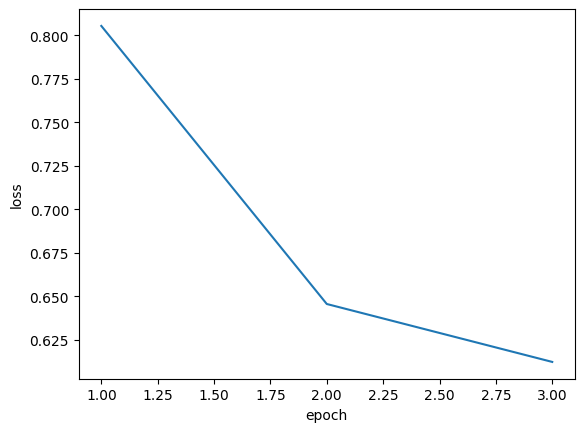

Loss: 0.5983 :   8%|▊         | 100/1242 [00:04<00:48, 23.77it/s] 


KeyboardInterrupt: 

In [22]:
losses = []

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    with tqdm.tqdm(total=len(dataloader)) as prbar:
        for i, batch in enumerate(dataloader):
            loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
            epoch_loss += loss
        
            if i % 100 == 0:
                #print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
                metrics_str = f"Loss: {round(loss, 4)} "
                #for k, v in metrics_dict.items():
                #    metrics_str += f"{k}: {round(float(v), 4)} "
                prbar.set_description(metrics_str)
                prbar.update(100)
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    #torch.save(model.state_dict(), "rnn.pt")
    torch.save(model, "rnn.pt")

In [23]:
torch.save(model, "rnn.pt")

In [24]:
#model.load_state_dict(torch.load("rnn.pt", weights_only=True))
model = torch.load("rnn.pt", weights_only=False)


model.eval()

CharRNN(
  (encoder): Embedding(522, 512)
  (rnn): LSTM(512, 512, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (decoder): Linear(in_features=512, out_features=522, bias=True)
)

In [25]:
[model.inference("Пилите, Шура, пилите. Они ", device=device) for _ in range(10)]

['<bos>пилите, шура, пилите. они деревятка горы.<eos>',
 '<bos>пилите, шура, пилите. они взятд невозможны...<eos>',
 '<bos>пилите, шура, пилите. они вместе и выровдет две июляте.<eos>',
 '<bos>пилите, шура, пилите. они теперь не заплатили.<eos>',
 '<bos>пилите, шура, пилите. они 151 уратры в нашем соге их гостей не закрывают раньших, можно выйти вкладок "убрать".<eos>',
 '<bos>пилите, шура, пилите. они все серьезно услышали на гоморя к ладому в шипочок малосы, орме по пользу слова домлово предым!<eos>',
 '<bos>пилите, шура, пилите. они ремонтные литушки и 42 года, но маленьких оператор.<eos>',
 '<bos>пилите, шура, пилите. они выпускают мужикну, и комедия, от ушей. блинка опаздывают как говорит бабушкой: "абоненточки познавали".<eos>',
 '<bos>пилите, шура, пилите. они верят только умное умеют запах - это когда на трупы можно. пустить толстый будет, потому что в жопе.<eos>',
 '<bos>пилите, шура, пилите. они какжа намекают в необходимо он жизнь. теперь мотодок много.<eos>']

## Задача 2. 3 балла
Реализуйте с помощью только torch/numpy слой RNN, обучите его на данных из классной работы и, опционально, своих данных. Покажите, что модель обучается
## {*} Задача 2.1 +1 балл
За реализацию слоев GRU/LSTM/bidirectional RNN, многослойной модели по +1 баллу к базовым (даже если ванильная RNN не реализована)

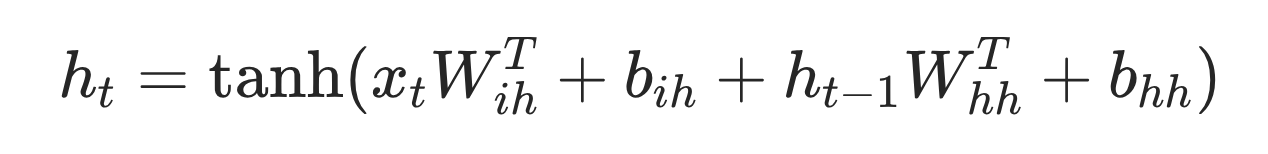
```python
self.rnn = nn.RNN(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
```

# Вопроc: зачем num_layers?

In [ ]:
class CustomRNN(nn.Module):
    def __init__(
            self,
            hidden_size:int,
            seq_len:int):
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size        
        
        super().__init__()
        self.hidden_size = hidden_size
        
        

        # Кратко поясню: сходимости не было, был либо разброс,
        #   либо затухание, поэтому nn

        self.Lh = nn.Linear(hidden_size, hidden_size)
        self.Lx = nn.Linear(hidden_size, hidden_size)
        #self.Wh = torch.rand(hidden_size, hidden_size, dtype=torch.float32, requires_grad=True)
        #self.Wx = torch.rand(hidden_size, hidden_size, dtype=torch.float32, requires_grad=True)
        self.Wh = torch.nn.utils.spectral_norm(self.Wh)

        self.bh = torch.rand((1, hidden_size), dtype=torch.float32, requires_grad=True)

    def forward(self, x):
        h_0 = torch.zeros((batch_size, self.hidden_size), dtype=torch.float32)
        
        h_t_minus_1 = h_0
        h_t = h_0

        for t in range(self.seq_len):
            #h_t = torch.tanh(
            #    x[t] @ self.Wx.T
            #    + h_t_minus_1 @ self.Wh.T
            #    + self.bh
            #)
            h_t = self.Lh(h_t_minus_1) + self.Lx(x[t]) + self.bh

            h_t_minus_1 = h_t

        return h_t

## Задача 3. 1/2/3/4 балла
**TBD**: 
Попробуйте обучить рекуррентную сеть задаче классификации. Вы можете воспользоваться сторонними библиотеками для вашей работы, 
но модель и основной код должны быть написаны на pytorch. 

##  {*} Задача 4. 5/6/7/8 баллов
[ссылка](https://www.kaggle.com/t/b2ef08dc3ddf44f981e2ad186c6c508d)

Попробуйте обучить сверточную нейронную сеть задаче детекции людей на изображениях разного стиля. Вы можете воспользоваться сторонними библиотеками для вашей работы. Однако, за неисопользование полностью готовых скриптов обучения (как в классной работе) вы получите дополнительные2 балла